# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

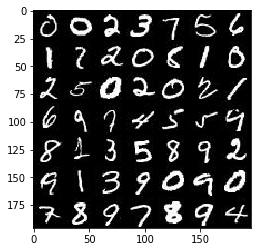

In [2]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

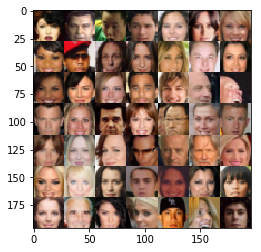

In [3]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')    
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # images shape = 28x28x3
        x1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, padding='same')
        relu1 = leaky_relu(x1)

        # relu1 shape = 14x14x64
        x2 = tf.layers.conv2d(inputs=relu1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        
        # relu2 shape 7x7x128
        x3 = tf.layers.conv2d(inputs=relu2, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3)
                
        # relu3 shape = 4x4x256
        flat = tf.reshape(tensor=relu3, shape=(-1, 4*4*256))
        logits = tf.layers.dense(inputs=flat, units=1)
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    with tf.variable_scope('generator', reuse = not is_train):
        
        # First fully connected layer
        flat = tf.layers.dense(z, 7*7*256)
#         print ('Flat:', flat.shape)

        # reshaping to start of convolutional stack, unflatten layer
        x1 = tf.reshape(flat, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        lrelu1 = leaky_relu(x1)
#         print ('Layer 1:', lrelu1.shape)

        # 7X7x256
        x2 = tf.layers.conv2d_transpose(inputs=lrelu1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = leaky_relu(x2)
#         print ('Layer 2:', lrelu2.shape)
        
        # 14x14x128
        x3 = tf.layers.conv2d_transpose(inputs=lrelu2, filters=64, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = leaky_relu(x3)
#         print ('Layer 3:', lrelu3.shape)
        
        # 28x28x64
        logits = tf.layers.conv2d_transpose(inputs=lrelu3, filters=out_channel_dim, kernel_size=5, strides=1, padding='same')       
#         print ('Output:', logits.shape)

        # Output layer, 28x28xout_channel_dim
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # discriminator generalization using smoothing
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)) * (1 - smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # use trainable_variables to get weights and bias to update
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimize    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):    
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
        return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    _, image_width, image_height, image_channels = data_shape
    
    # input placeholders
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # loss functions
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # optimization functions
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model

                steps += 1
                
                # Scale batch_images to -1 / 1 instead of -0.5 / 0.5
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
            
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr:learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr:learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1695... Generator Loss: 27.3281
Epoch 1/2... Discriminator Loss: 0.2479... Generator Loss: 9.8047
Epoch 1/2... Discriminator Loss: 0.4456... Generator Loss: 2.5214
Epoch 1/2... Discriminator Loss: 0.5387... Generator Loss: 2.3933
Epoch 1/2... Discriminator Loss: 0.1543... Generator Loss: 6.9876
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 0.9114
Epoch 1/2... Discriminator Loss: 0.5648... Generator Loss: 1.8840
Epoch 1/2... Discriminator Loss: 2.2651... Generator Loss: 0.1832
Epoch 1/2... Discriminator Loss: 0.5590... Generator Loss: 1.9028
Epoch 1/2... Discriminator Loss: 0.9605... Generator Loss: 0.7345


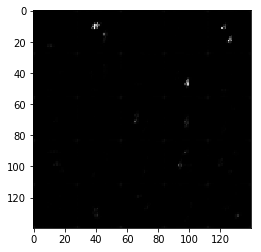

Epoch 1/2... Discriminator Loss: 1.3857... Generator Loss: 0.4672
Epoch 1/2... Discriminator Loss: 0.8537... Generator Loss: 2.0440
Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 0.9517
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.4174
Epoch 1/2... Discriminator Loss: 1.2590... Generator Loss: 0.5222
Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 0.4879
Epoch 1/2... Discriminator Loss: 1.5150... Generator Loss: 0.3684
Epoch 1/2... Discriminator Loss: 1.1303... Generator Loss: 2.1454
Epoch 1/2... Discriminator Loss: 0.9478... Generator Loss: 0.8165
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 0.9340


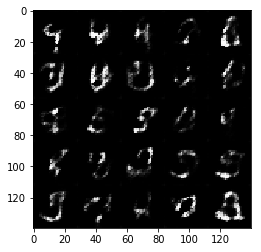

Epoch 1/2... Discriminator Loss: 0.9314... Generator Loss: 1.0108
Epoch 1/2... Discriminator Loss: 1.7821... Generator Loss: 2.3499
Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 0.8556
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 1.0416
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 0.5219
Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 1.4548
Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 2.5695
Epoch 1/2... Discriminator Loss: 0.9880... Generator Loss: 1.2553
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 0.5384
Epoch 1/2... Discriminator Loss: 1.1512... Generator Loss: 0.7326


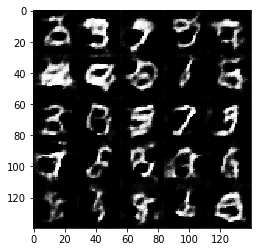

Epoch 1/2... Discriminator Loss: 1.6313... Generator Loss: 0.3495
Epoch 1/2... Discriminator Loss: 1.1671... Generator Loss: 1.4753
Epoch 1/2... Discriminator Loss: 1.1280... Generator Loss: 0.6333
Epoch 1/2... Discriminator Loss: 1.6229... Generator Loss: 0.2825
Epoch 1/2... Discriminator Loss: 1.0033... Generator Loss: 1.0401
Epoch 1/2... Discriminator Loss: 1.0379... Generator Loss: 1.0031
Epoch 1/2... Discriminator Loss: 1.4368... Generator Loss: 0.3710
Epoch 1/2... Discriminator Loss: 0.9328... Generator Loss: 0.9741
Epoch 1/2... Discriminator Loss: 1.1881... Generator Loss: 1.6705
Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 0.8107


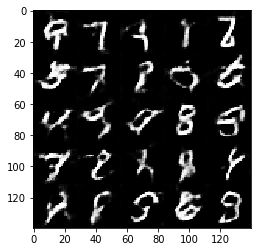

Epoch 1/2... Discriminator Loss: 1.0098... Generator Loss: 1.0838
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 1.3956
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 1.8421
Epoch 1/2... Discriminator Loss: 1.1551... Generator Loss: 0.8749
Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 0.5954
Epoch 1/2... Discriminator Loss: 1.0293... Generator Loss: 1.2231
Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 0.8038
Epoch 1/2... Discriminator Loss: 1.1689... Generator Loss: 0.6602
Epoch 1/2... Discriminator Loss: 0.9317... Generator Loss: 0.9830
Epoch 1/2... Discriminator Loss: 1.0506... Generator Loss: 0.7868


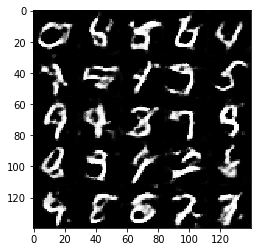

Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 1.1636
Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 0.6943
Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 0.7036
Epoch 1/2... Discriminator Loss: 1.3067... Generator Loss: 2.1191
Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 1.4278
Epoch 1/2... Discriminator Loss: 1.0275... Generator Loss: 1.0735
Epoch 1/2... Discriminator Loss: 0.9932... Generator Loss: 1.8070
Epoch 1/2... Discriminator Loss: 0.9558... Generator Loss: 1.3880
Epoch 1/2... Discriminator Loss: 1.8071... Generator Loss: 0.2494
Epoch 1/2... Discriminator Loss: 1.0003... Generator Loss: 0.8688


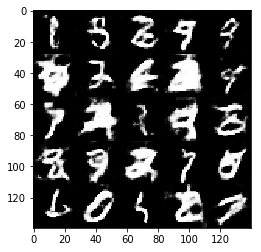

Epoch 1/2... Discriminator Loss: 0.9681... Generator Loss: 0.9630
Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 0.4791
Epoch 1/2... Discriminator Loss: 1.1943... Generator Loss: 0.4955
Epoch 1/2... Discriminator Loss: 1.1669... Generator Loss: 0.5404
Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.3955
Epoch 1/2... Discriminator Loss: 0.8672... Generator Loss: 1.1147
Epoch 1/2... Discriminator Loss: 1.0409... Generator Loss: 0.6856
Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 1.4110
Epoch 1/2... Discriminator Loss: 1.3982... Generator Loss: 0.5152
Epoch 1/2... Discriminator Loss: 1.0911... Generator Loss: 0.9818


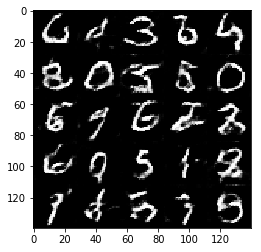

Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 1.5928
Epoch 1/2... Discriminator Loss: 1.2075... Generator Loss: 2.2220
Epoch 1/2... Discriminator Loss: 1.0686... Generator Loss: 1.2310
Epoch 1/2... Discriminator Loss: 0.9716... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 0.9376... Generator Loss: 1.0454
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 1.1559
Epoch 1/2... Discriminator Loss: 0.7378... Generator Loss: 1.1141
Epoch 1/2... Discriminator Loss: 2.2632... Generator Loss: 0.1638
Epoch 1/2... Discriminator Loss: 0.9071... Generator Loss: 0.9709
Epoch 1/2... Discriminator Loss: 0.9899... Generator Loss: 0.7031


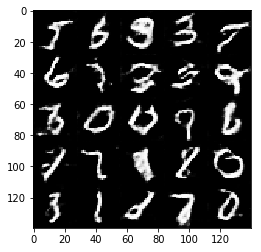

Epoch 1/2... Discriminator Loss: 0.8218... Generator Loss: 1.0211
Epoch 1/2... Discriminator Loss: 0.9719... Generator Loss: 0.8853
Epoch 1/2... Discriminator Loss: 0.8898... Generator Loss: 1.1869
Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 0.4570
Epoch 1/2... Discriminator Loss: 1.0120... Generator Loss: 0.7928
Epoch 1/2... Discriminator Loss: 1.0249... Generator Loss: 1.5724
Epoch 1/2... Discriminator Loss: 0.9102... Generator Loss: 1.8909
Epoch 1/2... Discriminator Loss: 1.5113... Generator Loss: 0.3912
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 0.6059
Epoch 1/2... Discriminator Loss: 0.9371... Generator Loss: 0.7527


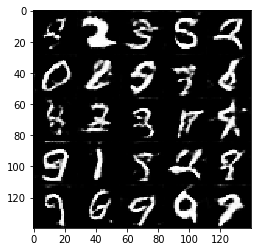

Epoch 1/2... Discriminator Loss: 1.0975... Generator Loss: 0.6885
Epoch 1/2... Discriminator Loss: 1.4984... Generator Loss: 0.4002
Epoch 1/2... Discriminator Loss: 1.0480... Generator Loss: 0.9132
Epoch 2/2... Discriminator Loss: 0.9449... Generator Loss: 0.9905
Epoch 2/2... Discriminator Loss: 1.0872... Generator Loss: 1.6900
Epoch 2/2... Discriminator Loss: 0.8078... Generator Loss: 1.7735
Epoch 2/2... Discriminator Loss: 1.0711... Generator Loss: 0.6064
Epoch 2/2... Discriminator Loss: 1.0454... Generator Loss: 0.6400
Epoch 2/2... Discriminator Loss: 0.9065... Generator Loss: 1.4637
Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 1.5280


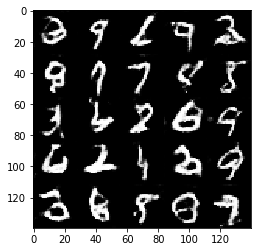

Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 1.8544
Epoch 2/2... Discriminator Loss: 0.9523... Generator Loss: 0.8271
Epoch 2/2... Discriminator Loss: 0.5208... Generator Loss: 1.5552
Epoch 2/2... Discriminator Loss: 4.0584... Generator Loss: 0.0363
Epoch 2/2... Discriminator Loss: 1.2072... Generator Loss: 0.5664
Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 0.7475
Epoch 2/2... Discriminator Loss: 0.7788... Generator Loss: 1.4830
Epoch 2/2... Discriminator Loss: 1.1879... Generator Loss: 0.5393
Epoch 2/2... Discriminator Loss: 0.8507... Generator Loss: 1.7323
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 0.7855


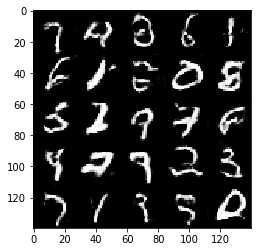

Epoch 2/2... Discriminator Loss: 0.8842... Generator Loss: 0.9693
Epoch 2/2... Discriminator Loss: 0.6262... Generator Loss: 2.0543
Epoch 2/2... Discriminator Loss: 0.8683... Generator Loss: 1.8212
Epoch 2/2... Discriminator Loss: 0.8518... Generator Loss: 0.9153
Epoch 2/2... Discriminator Loss: 0.6040... Generator Loss: 1.4290
Epoch 2/2... Discriminator Loss: 0.8002... Generator Loss: 1.2535
Epoch 2/2... Discriminator Loss: 0.7322... Generator Loss: 1.7551
Epoch 2/2... Discriminator Loss: 0.6489... Generator Loss: 1.3828
Epoch 2/2... Discriminator Loss: 2.6595... Generator Loss: 0.1472
Epoch 2/2... Discriminator Loss: 0.9225... Generator Loss: 0.9343


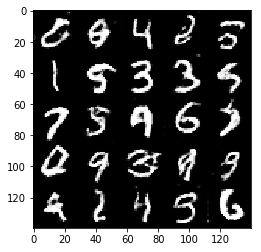

Epoch 2/2... Discriminator Loss: 0.7850... Generator Loss: 1.6129
Epoch 2/2... Discriminator Loss: 0.8357... Generator Loss: 1.2412
Epoch 2/2... Discriminator Loss: 0.8636... Generator Loss: 0.8330
Epoch 2/2... Discriminator Loss: 1.0369... Generator Loss: 1.7260
Epoch 2/2... Discriminator Loss: 1.0123... Generator Loss: 0.6456
Epoch 2/2... Discriminator Loss: 0.8592... Generator Loss: 0.7849
Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 2.2726
Epoch 2/2... Discriminator Loss: 1.7312... Generator Loss: 0.3761
Epoch 2/2... Discriminator Loss: 0.6467... Generator Loss: 1.3301
Epoch 2/2... Discriminator Loss: 0.6326... Generator Loss: 1.9833


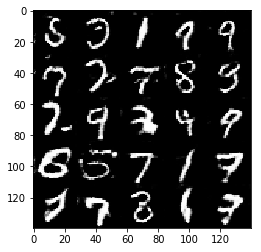

Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 0.7543
Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 2.3949
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 1.3652
Epoch 2/2... Discriminator Loss: 1.4768... Generator Loss: 0.3690
Epoch 2/2... Discriminator Loss: 1.2922... Generator Loss: 0.5239
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 3.0737
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 0.7885
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 0.6248... Generator Loss: 1.7183
Epoch 2/2... Discriminator Loss: 0.6578... Generator Loss: 1.0595


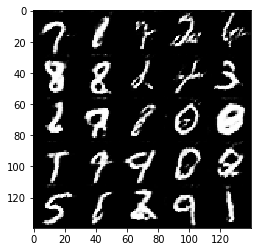

Epoch 2/2... Discriminator Loss: 0.9407... Generator Loss: 0.9628
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 1.0623
Epoch 2/2... Discriminator Loss: 0.6703... Generator Loss: 1.2381
Epoch 2/2... Discriminator Loss: 1.0009... Generator Loss: 0.6765
Epoch 2/2... Discriminator Loss: 1.1615... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.7720... Generator Loss: 0.2796
Epoch 2/2... Discriminator Loss: 0.9253... Generator Loss: 2.8127
Epoch 2/2... Discriminator Loss: 0.9518... Generator Loss: 2.3804
Epoch 2/2... Discriminator Loss: 1.2181... Generator Loss: 0.5529
Epoch 2/2... Discriminator Loss: 0.4519... Generator Loss: 1.4801


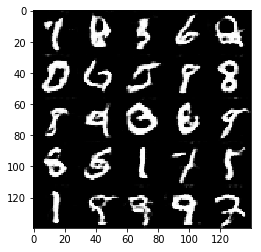

Epoch 2/2... Discriminator Loss: 0.4063... Generator Loss: 1.8333
Epoch 2/2... Discriminator Loss: 0.6895... Generator Loss: 1.0450
Epoch 2/2... Discriminator Loss: 0.8736... Generator Loss: 0.7591
Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 0.8781... Generator Loss: 0.8435
Epoch 2/2... Discriminator Loss: 0.9687... Generator Loss: 0.9718
Epoch 2/2... Discriminator Loss: 1.4917... Generator Loss: 0.4187
Epoch 2/2... Discriminator Loss: 0.7828... Generator Loss: 1.0175
Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 0.7511
Epoch 2/2... Discriminator Loss: 0.6015... Generator Loss: 1.4640


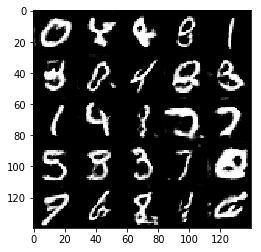

Epoch 2/2... Discriminator Loss: 1.6791... Generator Loss: 0.3838
Epoch 2/2... Discriminator Loss: 1.3892... Generator Loss: 0.4492
Epoch 2/2... Discriminator Loss: 0.7118... Generator Loss: 1.0524
Epoch 2/2... Discriminator Loss: 0.6059... Generator Loss: 1.1717
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 0.8699
Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 3.0210
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 2.0976
Epoch 2/2... Discriminator Loss: 0.5775... Generator Loss: 2.2505
Epoch 2/2... Discriminator Loss: 0.6764... Generator Loss: 1.2411
Epoch 2/2... Discriminator Loss: 0.8256... Generator Loss: 0.8647


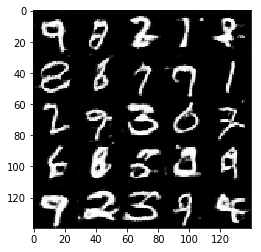

Epoch 2/2... Discriminator Loss: 0.4593... Generator Loss: 1.5054
Epoch 2/2... Discriminator Loss: 0.5341... Generator Loss: 1.8031
Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 0.9404
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 0.8544
Epoch 2/2... Discriminator Loss: 0.6851... Generator Loss: 1.1750
Epoch 2/2... Discriminator Loss: 0.7801... Generator Loss: 1.2460
Epoch 2/2... Discriminator Loss: 0.7066... Generator Loss: 3.3772
Epoch 2/2... Discriminator Loss: 1.0103... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 0.9560... Generator Loss: 0.7525
Epoch 2/2... Discriminator Loss: 0.3472... Generator Loss: 1.8520


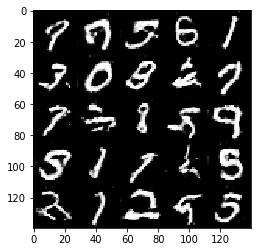

Epoch 2/2... Discriminator Loss: 0.8408... Generator Loss: 2.0171
Epoch 2/2... Discriminator Loss: 0.9257... Generator Loss: 0.7420
Epoch 2/2... Discriminator Loss: 0.5337... Generator Loss: 2.1553
Epoch 2/2... Discriminator Loss: 0.6278... Generator Loss: 1.8711
Epoch 2/2... Discriminator Loss: 0.7183... Generator Loss: 1.2689
Epoch 2/2... Discriminator Loss: 0.5418... Generator Loss: 1.2154
Epoch 2/2... Discriminator Loss: 0.8121... Generator Loss: 0.8129


In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1555... Generator Loss: 22.2976
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 21.9074
Epoch 1/1... Discriminator Loss: 2.3429... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.8071... Generator Loss: 5.5944
Epoch 1/1... Discriminator Loss: 0.6129... Generator Loss: 1.8107
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 0.3660... Generator Loss: 1.9996
Epoch 1/1... Discriminator Loss: 0.3527... Generator Loss: 5.1284
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 1.2715
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 3.8464


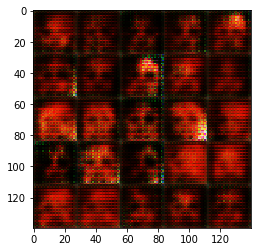

Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.4214
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 2.0267... Generator Loss: 0.2068
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 1.4172
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.5801
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 3.6025
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 1.4198


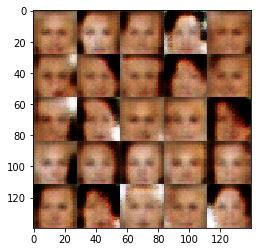

Epoch 1/1... Discriminator Loss: 1.8188... Generator Loss: 0.3097
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.1839
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.8664


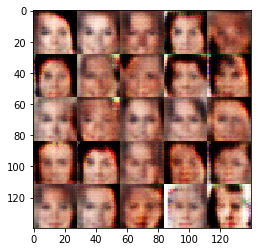

Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 1.7467
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 1.8986
Epoch 1/1... Discriminator Loss: 1.5922... Generator Loss: 1.3800
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 1.9650
Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 1.8174
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.4612
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.8502... Generator Loss: 0.6600


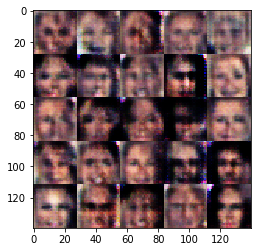

Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.2824
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.4059
Epoch 1/1... Discriminator Loss: 1.5998... Generator Loss: 1.7137
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.6832


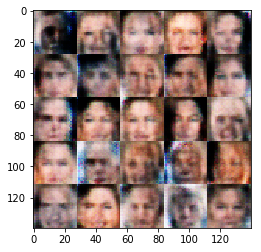

Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 1.2829
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.9989


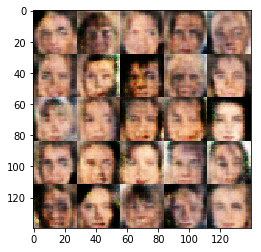

Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.3496
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.4195
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.3291
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.5015


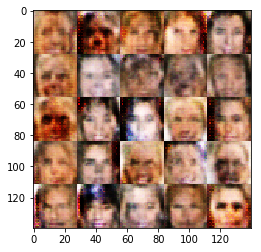

Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 1.3586
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8270


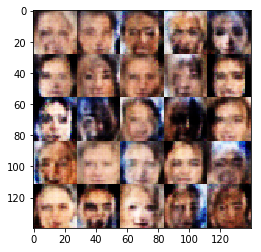

Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.3915
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 1.0368
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 1.0190


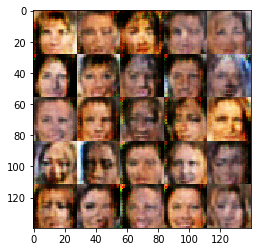

Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.9219


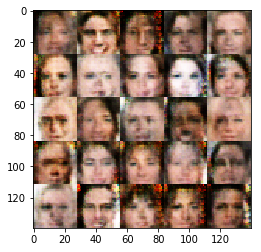

Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.8429


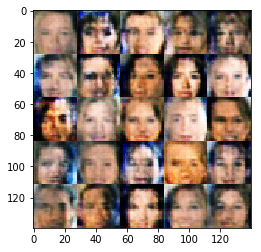

Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8714


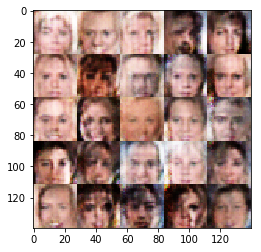

Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 1.1337
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.8240


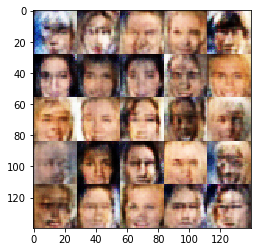

Epoch 1/1... Discriminator Loss: 1.5306... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.7947


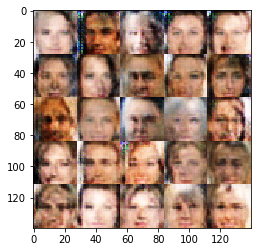

Epoch 1/1... Discriminator Loss: 1.6375... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.5286


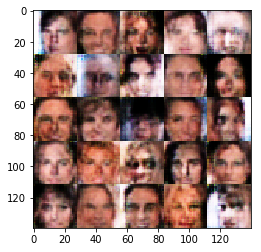

Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 1.2298
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.4194
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.7829


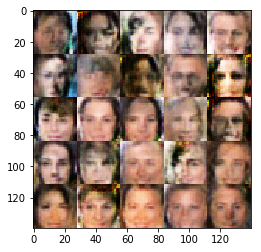

Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.5212
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.7644


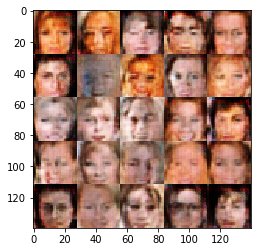

Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.5945... Generator Loss: 0.3247


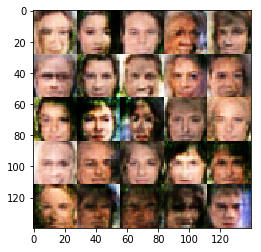

Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 1.0858


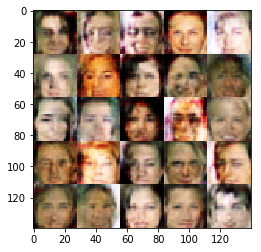

Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.4920


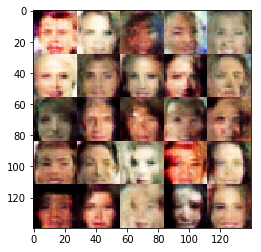

Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.1166
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 1.2817
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.6580


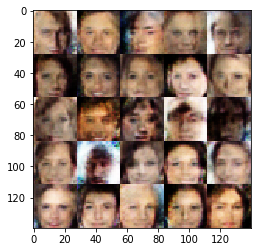

Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.7063


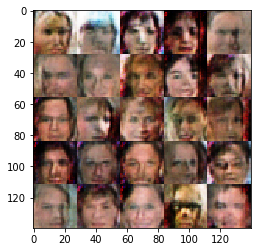

Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.7264


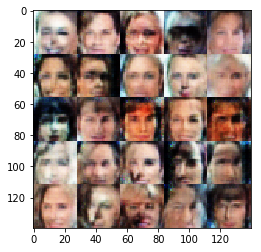

Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7303


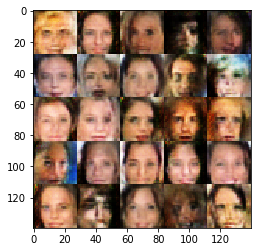

Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.5099
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.8020


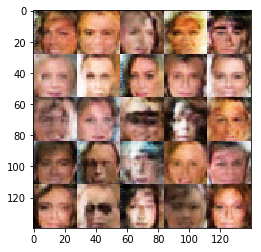

Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 1.2260
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.8965


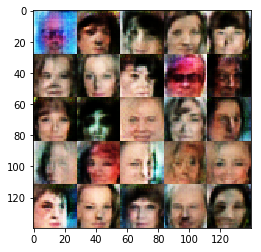

Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.5957


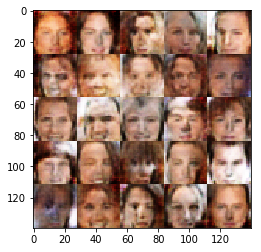

Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 1.3926
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 1.1713
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.8525


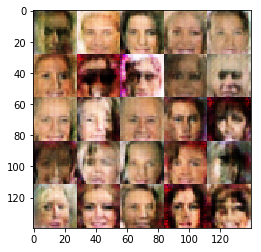

Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.6297


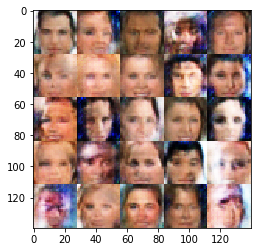

Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.7660


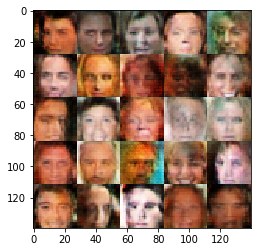

Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.8571


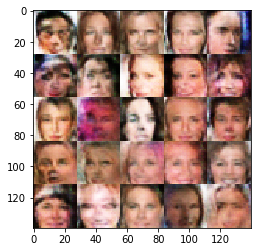

Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.7390


In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.